In [1]:
import pandas as pd
from methods import data_handler
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import os
from itertools import chain, product

/Users/julianvonklitzing/opt/anaconda3/envs/xai_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Bad key "text.kerning_factor" on line 4 in
/Users/julianvonklitzing/opt/anaconda3/envs/xai_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Read questionnaire information from picking procedure

In [2]:
questionnaires = data_handler.get_questionaires("data2/questionaires_shuffled.pickle")
labels = data_handler.get_labels()

Using downloaded and verified file: ./data/imagenet_class_index.json


In [3]:
def get_label_from_img_idx(img_idx, testset_path, labels):    
    img_folder = datasets.ImageFolder(root=testset_path)
    img_path = img_folder.imgs[img_idx][0]
    img_name = img_path.split(os.sep)[-1]
    # extract correct class
    class_idx_true_str = img_path.split(os.sep)[-2]
    img_label_true = labels[class_idx_true_str][1]
    return img_label_true

In [4]:
# enrich questionnaire data with image label names
questionnaires_2 = []
for questionnaire in tqdm(questionnaires):
    questionnaire_2 = []
    for question in questionnaire:
        label = get_label_from_img_idx(question[0], "data2/imagenetv2-matched-frequency-format-val", labels)
        question_labled = (label, ) + question        
        questionnaire_2.append(question_labled)
    questionnaires_2.append(questionnaire_2) 

100%|███████████████████████████████████████████| 12/12 [00:38<00:00,  3.18s/it]


## Load question codes used in SoSci

In [5]:
codes_list = []
for i in range(1, 12+1):
    codes = pd.read_csv(f"questionaires_shuffle_order/questionaire_{i}.txt", sep=";", names=[0, 1])[1]
    codes = codes.str.extract("(\w\d{3})")
    codes = list(codes[0])
    codes_list.append(codes)

## Create questions meta data df

In [6]:
df_quest_meta = pd.DataFrame(list(chain(*questionnaires_2)))
df_quest_meta[5] = list(chain(*codes_list))
df_quest_meta.columns = ["label", "img_idx", "model", "method", "is_pred_correct", "question_code"]

In [7]:
df_quest_meta

,label,img_idx,model,method,is_pred_correct,question_code
0,custard_apple,9521,vgg,LRP,True,B108
1,Boston_bull,1073,vgg,SHAP,True,B111
2,toilet_tissue,9992,alex,IntegratedGradients,False,B118
3,gas_pump,5253,vgg,ConfidenceScores,False,B123
4,mailbag,5976,vgg,IntegratedGradients,False,B124
...,...,...,...,...,...,...
283,custard_apple,9521,vgg,gradCAM,True,C307
284,coral_reef,9710,alex,gradCAM,True,C302
285,black_grouse,7798,alex,LRP,False,C319
286,steel_arch_bridge,8034,alex,SHAP,True,C317


## Load and transform questionnaire data

In [67]:
# data_tu-helpfulness-of-xai_2022-06-21_17-15.xlsx
df = pd.read_excel("data2/data_tu-helpfulness-of-xai_2022-06-23_20-20.xlsx")

In [69]:
df_demo = df[df.columns[df.columns.get_loc("DE02"):df.columns.get_loc("FB01_01")+1]] 
df_demo = df_demo.apply(lambda s: s.repeat(24)).reset_index(drop=True)
df_demo

,DE02,DE02_06,DE07,DE09,DE05,DE05_01,DE08,FB01_01
0,Education,Education: Other,ML Experience,XAI Experience,Color Blindness,Color Blindness: Yes,Visual Impairment Affect,Feedback Form: [01]
1,Education,Education: Other,ML Experience,XAI Experience,Color Blindness,Color Blindness: Yes,Visual Impairment Affect,Feedback Form: [01]
2,Education,Education: Other,ML Experience,XAI Experience,Color Blindness,Color Blindness: Yes,Visual Impairment Affect,Feedback Form: [01]
3,Education,Education: Other,ML Experience,XAI Experience,Color Blindness,Color Blindness: Yes,Visual Impairment Affect,Feedback Form: [01]
4,Education,Education: Other,ML Experience,XAI Experience,Color Blindness,Color Blindness: Yes,Visual Impairment Affect,Feedback Form: [01]
...,...,...,...,...,...,...,...,...
3187,2,NaN,2,3,2,NaN,NaN,NaN
3188,2,NaN,2,3,2,NaN,NaN,NaN
3189,2,NaN,2,3,2,NaN,NaN,NaN
3190,2,NaN,2,3,2,NaN,NaN,NaN


In [55]:
df_long

,case,question_code,response
20064,579,B709,False
20328,579,B711,True
19932,579,B708,True
22044,579,B724,True
20460,579,B712,True
...,...,...,...
21251,1626,B717,False
21383,1626,B718,False
21515,1626,B719,False
19403,1626,B703,False


In [66]:
df

,case,question_code,response,DE02,DE02_06,DE07,DE09,DE05,DE05_01,DE08,FB01_01
0,579,B709,False,1,NaN,1,NaN,2,NaN,NaN,NaN
1,579,B711,True,1,NaN,1,NaN,2,NaN,NaN,NaN
2,579,B708,True,1,NaN,1,NaN,2,NaN,NaN,NaN
3,579,B724,True,1,NaN,1,NaN,2,NaN,NaN,NaN
4,579,B712,True,1,NaN,1,NaN,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3163,1626,B717,False,2,NaN,2,3,2,NaN,NaN,NaN
3164,1626,B718,False,2,NaN,2,3,2,NaN,NaN,NaN
3165,1626,B719,False,2,NaN,2,3,2,NaN,NaN,NaN
3166,1626,B703,False,2,NaN,2,3,2,NaN,NaN,NaN


In [63]:
def convert_q_data_from_wide_to_long(df):
    column_names_demographic = list(df[df.columns[df.columns.get_loc("DE02"):df.columns.get_loc("FB01_01")+1]].loc[0])
    #delete column descriptions
    df = df.drop(0)
    
    df_long = pd.melt(df, id_vars="CASE", value_vars=df.columns.values[6:294]).dropna()
    df_long.columns = ["case", "question_code", "response"]
    df_long = df_long.sort_values("case", )
    # map response 1(Yes)/2(No) values to True/False
    df_long["response"] = df_long["response"].apply(lambda x: True if x==1 else False)
    df_long = df_long.reset_index(drop=True)
    
    df_demo = df[df.columns[df.columns.get_loc("DE02"):df.columns.get_loc("FB01_01")+1]] 
    df_demo = df_demo.apply(lambda s: s.repeat(24)).reset_index(drop=True) 
    df_long = pd.concat([df_long, df_demo], axis=1)
    return df_long

In [64]:
df_long = convert_q_data_from_wide_to_long(df)

In [65]:
df_long

,case,question_code,response
0,579,B709,False
1,579,B711,True
2,579,B708,True
3,579,B724,True
4,579,B712,True
...,...,...,...
3163,1626,B717,False
3164,1626,B718,False
3165,1626,B719,False
3166,1626,B703,False


# Analysis

In [12]:
df_merged = df_long.merge(right=df_quest_meta)
df_merged = df_merged.sort_values("case")

In [13]:
df_merged

,case,question_code,response,label,img_idx,model,method,is_pred_correct
0,579,B709,False,coral_reef,9710,vgg,LRP,True
110,579,B702,False,matchstick,6063,vgg,ConfidenceScores,False
50,579,B713,True,sidewinder,6453,alex,gradCAM,False
60,579,B714,True,face_powder,5037,alex,LIME,False
70,579,B715,False,chiffonier,4389,alex,SHAP,True
...,...,...,...,...,...,...,...,...
149,1626,B707,True,slide_rule,7769,alex,gradCAM,True
189,1626,B703,False,gyromitra,9931,alex,LIME,True
139,1626,B704,False,Boston_bull,1073,alex,SHAP,False
229,1626,B719,False,mortar,6303,alex,LRP,False


## Metrics on all images (fixed + random)

### Overall ability to guess model is correct if actually correct

In [14]:
num_guessed_correct_if_correct = df_merged[(df_merged["is_pred_correct"] == True) & (df_merged["response"] == True)].shape[0]
num_correct_overall = df_merged[df_merged["is_pred_correct"] == True].shape[0]

In [15]:
num_guessed_correct_if_correct / num_correct_overall

0.6306818181818182

### Overall ability to guess model is wrong if actually wrong

In [16]:
num_guessed_wrong_if_wrong = df_merged[(df_merged["is_pred_correct"] == False) & (df_merged["response"] == False)].shape[0]
num_wrong_overall = df_merged[df_merged["is_pred_correct"] == False].shape[0]

In [17]:
num_guessed_wrong_if_wrong / num_wrong_overall

0.5473484848484849

### Ability for each XAI-method to guess model is correct/wrong if actually correct/wrong

In [18]:
def create_individual_ratios(df_merged):
    df_ratios_per_method = df_merged.groupby(by=["method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]
    return df_ratios_per_method

In [19]:
def create_individual_ratios_all(df_merged):
    test = pd.DataFrame(list(product(df_ratios_per_method_case["case"].drop_duplicates(), df_ratios_per_method_case["method"].drop_duplicates(), df_ratios_per_method_case["is_pred_correct"].drop_duplicates(), df_ratios_per_method_case["response"].drop_duplicates()))).groupby([0, 1, 2, 3]).count()
    test = test.reset_index()
    test.columns=['case', 'method', 'is_pred_correct', 'response']
    
    df_ratios_per_method = df_merged.groupby(by=["method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]
    return df_ratios_per_method

In [20]:
df_ratios_per_method = create_individual_ratios(df_merged)

In [21]:
df_ratios_per_method

,method,is_pred_correct,response,ratio
0,ConfidenceScores,False,False,0.647727
1,ConfidenceScores,True,True,0.753788
2,IntegratedGradients,False,False,0.507576
3,IntegratedGradients,True,True,0.560606
4,LIME,False,False,0.511364
5,LIME,True,True,0.583333
6,LRP,False,False,0.420455
7,LRP,True,True,0.742424
8,SHAP,False,False,0.772727
9,SHAP,True,True,0.352273


In [22]:
def plot_ratios(df_ratios_per_method, title_addition=""):        
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.scatter(x=df_ratios_per_method["method"].drop_duplicates(), y=df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"], c="orange", label="Guessed Correct when Model Correct")
    ax.scatter(x=df_ratios_per_method["method"].drop_duplicates(), y=df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"], c="purple", label="Guessed Wrong when Model Wrong")
    ax.plot(df_ratios_per_method["method"], [0.5] * len(df_ratios_per_method), color="red", linestyle='dashed', label="baseline")
    ax.set_title(f"{title_addition} Performance Ratios for chosen XAI-Methods ({len(df)} participants considered)", size=15)
    ax.set_xlabel("XAI-Method", size=13)
    ax.set_ylabel("Ratio", size=13)
    for i, txt in enumerate(df_ratios_per_method["ratio"].round(2)):
        ax.annotate(txt, (list(df_ratios_per_method["method"])[i], list(df_ratios_per_method["ratio"])[i]))
    ax.legend(loc="best", edgecolor="black")

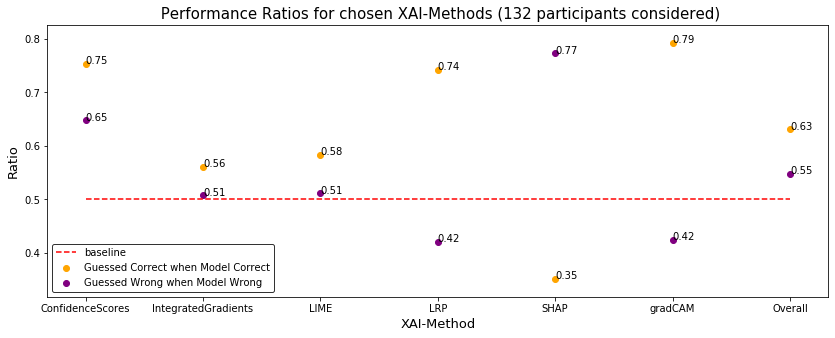

In [23]:
plot_ratios(df_ratios_per_method)

In [24]:
"""
Further possible analysis:
 -Calculate all these measures for each questionaire, to see if there were super hard ones (generally inspect varinace)
 -Visualize true/false as 2x2 confusion matrix
 -Convergence of ratio values as more and more participants get in
 -Demographical questions must be taken into account
 -Analyzing participants: time taken to finish servey, all-false, all-true 
"""

'\nFurther possible analysis:\n -Calculate all these measures for each questionaire, to see if there were super hard ones (generally inspect varinace)\n -Visualize true/false as 2x2 confusion matrix\n -Convergence of ratio values as more and more participants get in\n -Demographical questions must be taken into account\n -Analyzing participants: time taken to finish servey, all-false, all-true \n'

## Metrics only on fixed images

In [25]:
fixed_img_idxs = df_quest_meta["img_idx"].value_counts()[df_quest_meta["img_idx"].value_counts() == 12].index
df_quest_meta_fixed = df_quest_meta[df_quest_meta["img_idx"].isin(fixed_img_idxs)]

In [26]:
df_merged_fixed = df_long.merge(right=df_quest_meta_fixed)
df_merged_fixed = df_merged_fixed.sort_values("case")

In [27]:
df_ratios_per_method_fixed = create_individual_ratios(df_merged_fixed)

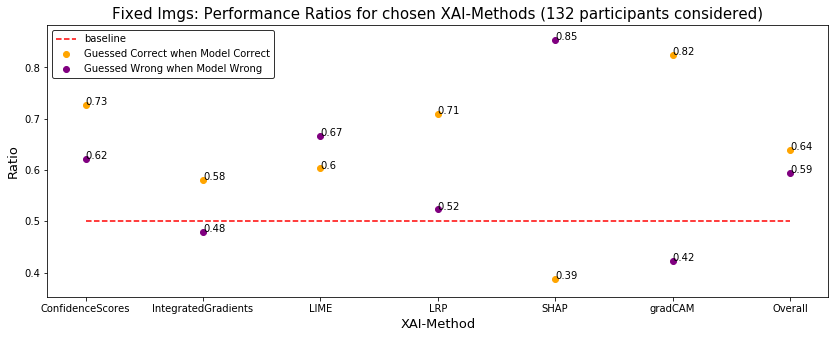

In [28]:
plot_ratios(df_ratios_per_method_fixed, "Fixed Imgs:")

## Convergence of ratio values as more participant results are taken into account

In [29]:
def create_individual_ratios_per_participant(df_merged):
    # df_schema needed to get all TP,TN,FP,FN i.e. where value_counts() would evaluate nothing because not existent (0)
    df_schema = pd.DataFrame(list(product(df_merged["case"].drop_duplicates(), df_merged["method"].drop_duplicates(), df_merged["is_pred_correct"].drop_duplicates(), df_merged["response"].drop_duplicates()))).groupby([0, 1, 2, 3]).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=['case', 'method', 'is_pred_correct', 'response']
    df_ratios_per_method_and_part = df_merged.groupby(by=["case", "method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method_and_part = df_schema.merge(right=df_ratios_per_method_and_part, on=["case", "method", "is_pred_correct", "response"], how="left")
    df_ratios_per_method_and_part = df_ratios_per_method_and_part.fillna(0)
    # only filter for TP and TP (just for now, might get modified)
    df_ratios_per_method_and_part = df_ratios_per_method_and_part[df_ratios_per_method_and_part["is_pred_correct"] == df_ratios_per_method_and_part["response"]].reset_index(drop=True)
    return df_ratios_per_method_and_part.groupby(by=["method", "is_pred_correct"]).expanding().mean()#.reset_index(level=2, drop=True)
    #return df_ratios_per_method_and_part
    
    # df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    # df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    # df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]


In [30]:
df_ratios_convergence = create_individual_ratios_per_participant(df_merged)
df_ratios_convergence

case  response     ratio
method           is_pred_correct                                      
ConfidenceScores False           0      579.000000       0.0  1.000000
                                 12     580.000000       0.0  0.500000
                                 24     582.333333       0.0  0.500000
                                 36     584.000000       0.0  0.500000
                                 48     588.200000       0.0  0.600000
...                                            ...       ...       ...
gradCAM          True            1535  1107.906250       1.0  0.792969
                                 1547  1111.782946       1.0  0.794574
                                 1559  1115.615385       1.0  0.788462
                                 1571  1119.465649       1.0  0.790076
                                 1583  1123.303030       1.0  0.791667

[1584 rows x 3 columns]

In [31]:
def plot_ratio_convergence(df_ratios_convergence):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_xlabel("Number Participants", size=13)
    ax.set_ylabel("Ratio", size=13)
    ax.set_title("Convergence of Ratios as Ratios are calculated over increasing Numbers of Participants", size=15)
    for method in df_ratios_convergence.index.get_level_values(0).drop_duplicates():
        for outcome in df_ratios_convergence.index.get_level_values(1).drop_duplicates():
            ax.plot(list(range(len(df_ratios_convergence.loc[method, outcome]))), df_ratios_convergence.loc[method, outcome]["ratio"], label=f"{method}, {outcome}")
            # print(df_ratios_convergence.loc[method, outcome]["ratio"].iloc[-1])
    ax.legend(loc="lower center", edgecolor="black")

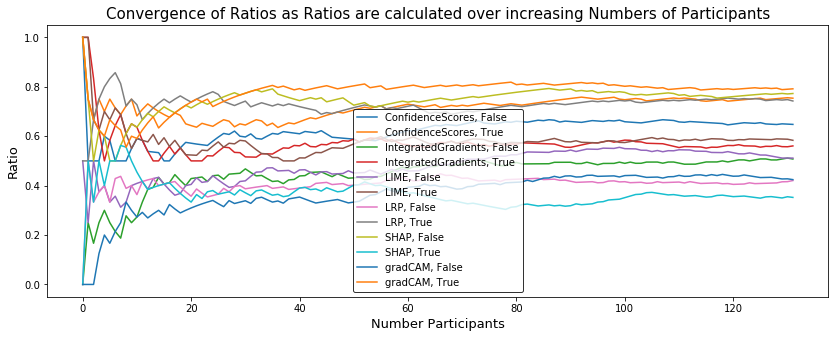

In [32]:
plot_ratio_convergence(df_ratios_convergence, )